In [1]:
pip install gluonts[mxnet]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.5 MB/s 
     |████████████████████████████████| 49.1 MB 1.9 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.mx import DeepAREstimator, Trainer

/usr/local/lib/python3.8/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [15]:
import pandas as pd
df = pd.read_excel('/content/Solar station site 1 (Nominal capacity-50MW).xlsx')

In [16]:
df.head()

,Time(year-month-day h:m:s),Total solar irradiance (W/m2),Direct normal irradiance (W/m2),Global horizontal irradiance (W/m2),Air temperature (°C),Atmosphere (hpa),Relative humidity (%),Power (MW)
0,2019-01-01 00:00:00,0,0,0,-11.7,930.5,39.1,0.0
1,2019-01-01 00:15:00,0,0,0,-11.8,930.5,39.3,0.0
2,2019-01-01 00:30:00,0,0,0,-11.4,930.5,39.0,0.0
3,2019-01-01 00:45:00,0,0,0,-11.5,930.5,38.0,0.0
4,2019-01-01 01:00:00,0,0,0,-11.5,930.4,38.9,0.0


In [17]:
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(10,8)
mpl.rcParams['axes.grid']=False

In [18]:
for dataset in [df]:
    dataset.columns=['time','TSI','DNI','GHI','Air_T','Air_P','Air_H','Power(MW)']

In [19]:
color_list =[
    'blue','orange','green','red','purple','brown','pink','gray','olive','cyan'
]

In [20]:
date_key='time' 

In [22]:
df= df.set_index('time')

In [21]:
df.time=pd.to_datetime(df["time"], format = "%Y-%m-%d %H:%M:%S", errors = "coerce")

In [23]:
train_time='2020-08-01 00:00:00'
prediction_length=96

In [24]:
estimator =DeepAREstimator(
    freq="15min",
    context_length=480,
    prediction_length=96,
    num_layers=2,
    num_cells=128,
    cell_type='lstm',
    trainer=Trainer(epochs=8) 
)

In [25]:
from gluonts.dataset.common import ListDataset

training_data =ListDataset(
    [{"start":df.index[0],"target":df["Power(MW)"][:train_time]}],
    freq="15min"
)

In [26]:
predictor= estimator.train(training_data=training_data)

100%|██████████| 50/50 [03:10<00:00,  3.82s/it, epoch=8/8, avg_epoch_loss=0.678]


In [27]:
test_data=ListDataset(
    [
        {"start":df.index[0],"target":df["Power(MW)"][:"2020-07-05 00:00:00"]},
        {"start":df.index[0],"target":df["Power(MW)"][:"2020-08-10 00:00:00"]}
    ],
    freq="15min"
)

In [28]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [29]:
forecast_it,ts_it =make_evaluation_predictions(
    dataset=test_data,
    predictor=predictor,
    num_samples=100
)

In [30]:
forecasts=list(forecast_it)
tss=list(ts_it)

In [31]:
forecast_entry =forecasts[0]

In [40]:
from google.colab import files
def plot_prob_forecasts(ts_entry,forecast_entry):
  plot_length = prediction_length
  prediction_intervals=(80.0,95.0)
  legend=["observations","median prediction"]+[f"{k}% prediction interval"for k in prediction_intervals][::-1]

  fig,ax= plt.subplots(1,1,figsize=(10,7))
  ts_entry[-plot_length:].plot(ax=ax)
  forecast_entry.plot(prediction_intervals=prediction_intervals,color='g')
  plt.grid(which='both')
  plt.legend(legend,loc='upper left')
  plt.savefig('./forecasts')

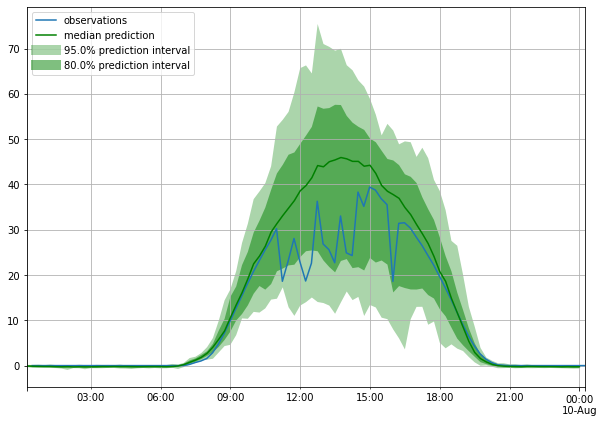

In [41]:

plot_prob_forecasts(tss[1],forecasts[1])

In [34]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1,0.5,0.9])
agg_metrics,item_metrics= evaluator(iter(tss),iter(forecasts),num_series=len(test_data))

Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 37.60it/s]


In [35]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,None,2020-07-04 00:15,5.984238,196.838196,1193.750122,12.434897,3.021723,0.678553,0.281781,0.913206,0.164891,4.66602,72.116160,0.000000,196.838187,0.510417,93.916432,0.750000
1,None,2020-08-09 00:15,33.854523,335.641296,1054.659912,10.986041,3.046953,1.147462,0.318633,1.010939,0.318246,5.73137,89.551666,0.041667,335.641307,0.427083,133.070229,0.708333
